# M1v.2 Dataset postprocessing and EDA 
This notebook is the revised form of the previously submitted M1 deliverable. 

**TL;DR: What changed in the dataset**
- Extracting the mean bioclimatic features from previously 2001-2012 to **1991-2000**;
- Removing of the differential variables (like difference in height, biomass) between two acquisition periods (2002/2012); (no regression task)
- Removing variables on the single tree level that are not likely to be derivable by RS or EO data (see main target of the dataset);
- Removing categorical variables that are binned representations of already present numerical variables;
- New dataset consists of 46 variables (12 categorical, 34 numerical);
- Numerical variables form two groups: tree parameters (height, diameter, volume ...) and climate/geographical exposure that correlated within;
- PCA of the numerical variables indicates that the number can be reduced by half achieving 99% explainable variance for the numerical features;
- Some categorical variables might not contribute much to the differentiation of tree species due to imbalanced counts per species (spruce is dominated overall). However, the might allow to distinguish between coniferous and deciduous species and douglas fir (coniferous target species);
- A combination of Tnr and Enr (grid and sampleplot level) will be used to group instances in stratified cross-validation since both aggregation levels are present in all instances. 

## Main target of the dataset
The main target of the dataset is to train multiple classifiers for tree species. Its features are customly selected from multiple databases of the National Forest Inventory of Germany (engl.: NFI, germ.: BWI). *The dataset therefore does not include any RS derived features.* However, in the following EDA and post-processing of the dataset features prioritized that hold information that could *possibly* be infered from remote sensing data.

At the end of this notebook the a final dataset for classifier training is exported to the repository.

## NFI and aggregation levels 
- **The NFI is based on a regular grid of varying density (depending on the region)**
    - The base density is 4x4km up to 2x2km; 
    - Vertices are unique accross Germany; 
    - At each vertex 4 samplings are conducted at the corners of a 150x150m square with the position of its lower left corner being equal to the grid vertices. 
    - At each sampling plot, single tree and forest stand parameters are measured and/or modelled using different techniques.

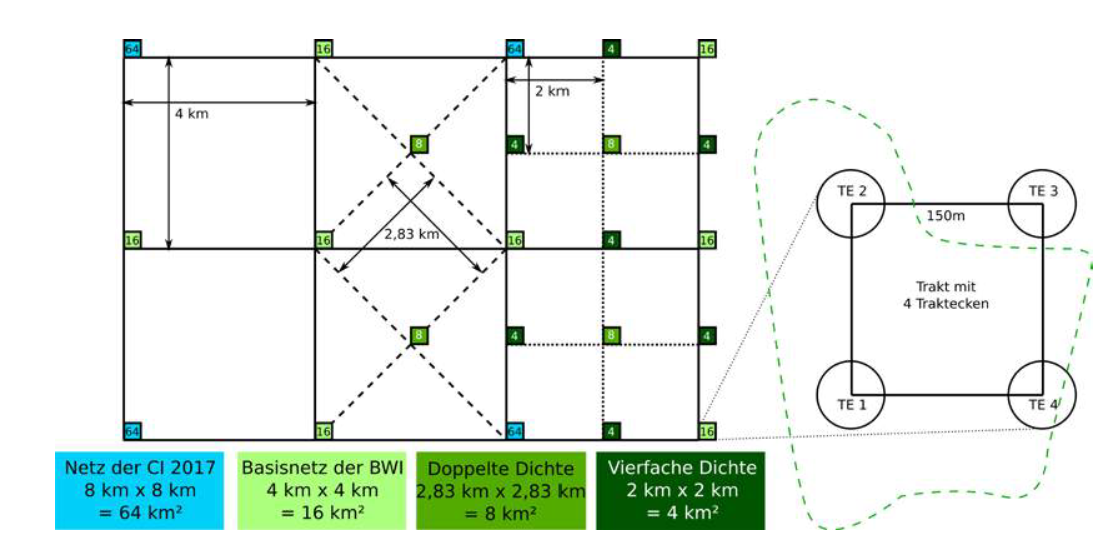

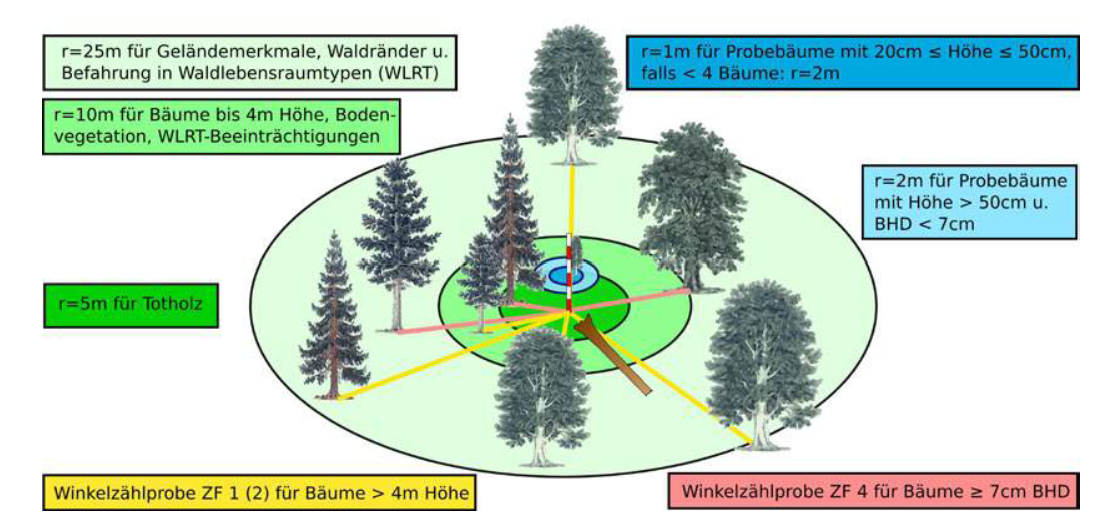

In [179]:
from PIL import Image
from IPython.display import display
display(Image.open('./imgs/grid_info.png'))
display(Image.open('./imgs/sample.png'))

### See feature descriptions of input dataset below

In [2]:
from IPython.display import Markdown

# Read the file and display the table
file_path = '../documentation/features.md'
with open(file_path, 'r') as file:
    content = file.read()

# Display the content as markdown
display(Markdown(content))

# Feature descriptions
**This supplementary document includes the explanations for all 105 features 
that are present in the dataset after its generation using the scripts of 
this repository.**




| Feature         | Description | Type |
|:----------------|:------------|------:|
| Tnr             |'Traktnummer': Identifier of grid points **unique across Germany**. | Numerical/Identifier |
| Enr             |'Eckennummer: Identifer of the sampling plot **1-4 unique for each grid point** | Numerical identifier |
| Bnr             |'Baumnummer: Treenumber **unique within each sampling plot** | Numerical identifier | 
| Av              |Measurement/estimation methods used | Categorical |
| Ba              |'Baumart: Tree species | Categorical **TARGET**|
| Al_ba           |'Baumalter: Tree age [$a$] | Numerical |
| Bs              |'Bestandesschicht': Canopy layer | Categorical |
| Bhd             |'Brusthöhendurchmesser: Diamerter at breast height [$mm$] | Numerical |
| Hoehe           |'Höhe': Height [$dm$ | Numerical |
| D7              |Diameter at 0.7 percentile of tree height | Numerical |
| D03             |Diameter at 0.3 percentile of tree hieght | Numerical 
| G               |'Grundfläche': Basal area [$m^2$] | Numerical | 
| VolR            |'Volumen Vorratsfestmeter': Volume with bark [$m^3$] | Numerical |
| VolR_FAO        |'Volumen Vorratsfestmeter - FAO': Volume with bark [$m^3$] | Numerical |
| VolE            |'Volumen Erntefestmeter': Volume without bark [$m^3] | Numerical |
| vVolE           |'verwendbarer Erntefestmeter': Volume without bark sawwood ready [$m^3$] | Numerical |
| N_ha            |'Stammzahl je Hektar': Number of trees per hectar | Numerical |
| Stf             |'Standfläche': 'Canopy footprint' [$m^2$] | Numerical |
| StfM            |Normalized version of Stf (to fit 1ha) |
| Bhdst1          |'Brusthöhendurchmesserstufe - 1cm': DBH in 1cm bins | Numerical |
| Bhdst5          |'Brusthöhendurchmesserstufe - 5cm': DBH in 5cm bins |Numerical |
| Alkl5           |'Altersklasse Jahresstufe - 5': Age in 5 year bins | Numerical |
| GrGr2           |'Größenklassenstufe': Height and diameter binning | Categorical |
| jSchael_x       |'Frische Schälschäden': New (<12 months) damages bark peeling (Yes / No) | Numerical |
| Biom_o          |'Biomasse oberirdisch': Aboveground biomass [$kg$] | Numerical |
| Biom_u          |'Biomasse unterirdisch': Belowground biomass [$kg$] |Numerical |
| Biov_o          |'Biomasse überirdisch' : Aboveground biomass[$m^3$] | Numerical |
| Gexp            |'Geländexposition': Aspect [$gon$] | Numerical | 
| GExpKl4         |'Geländeexpositionsklasse': Aspect in classes (4) | Numerical |
| GExpKl8         |'Geländeexpositionsklasse: Aspect in classes (8) | Numerical |
| Gform           |'Geländeform': Terrain | Categorical |
| Gneig           |'Geländeneigung': Slope [$\%$] | Numerical |
| GneigKl5        |'Geländeneigunsklassen - 5': Slope categories (5) [$\%$] | Numerical |
| natHoe          |'natürliche Höhenstufe': natural height class | Categorical |
| potNatWg        |'potenzielle natürliche Waldgesellschaft': potential natural forest community | Categorical |
| HoeheNN         |'Höhe NN': Height above German normal height [$m$] | Numerical |
| hnnSt100        |'Höhenstufe 100': Height in 100m bins | Categorical
| hnnSt250        |'Höhenstufe 250': Height in 250m bins |  / Categorical
| Zaun            |'Zaun': Fenced (Yes/No) | Categorical 
| Be              |'Betriebsart': Operation catgeory | Categorical |
| NatNaeheHaupt   |'Ermittelte Naturnähe (durch Hauptbestand WZP-4)': Estimated closeness to nature (using the main canopy layer) |  Categorical |
| NatNaeheLT7cm   |'Ermittelte Natunähe (bis Größeklasse 6) Probekreise 1-4m: Estimated closeness to nature (up to height class 6 and sample radii 1-4m) |  Categorical |
| ForestType      |European Forest Type | Categorical |
| RAN             |'Anzahl Wald und Bestandesränder': Number of forest/foreststand edges | Numerical | 
| Situation       |'Besondere Bestandessituation': Special forest stand situation | Categorical |
| TOT             |'Anzahl Totholzstücke': Pieces of deadwood | Numerical | 
| Kaefer          |'Käferlöcher': Bettle boreholes (Yes / No) | Categorical |
| jSchael_y       |**same as jSchael_x - doubled entry** |
| aeSchael        |'Ältere Schälschäden': Older peeling damages (> 12 months) (Yes / No) | Categorical |
| Bkl             |'Baumklasse': Tree social class | Categorical |
| Ast             |'Astung'| Categorical |
| tot             |'Zeitpunkt tot': Tree is dead or not | Categorical | 
| AnzSchad        |'Anzahl Schäden am Baum bis 8': Number of damages (max 8) | Numerical |
| Ruecke          |'Rücke- oder Fällschäden': Damages due to felling or logging (Yes / No) | Categorical |
| Specht          |'Specht': Woodpecker (Yes / No) | Categorical |
| Pilz            |'Pilzkonsolen': Mushroom (Yes / No) | Categorical |
| Harz            |'Harz': Resin (Yes / No) | Categorical | 
| BestockAb       |'Bestockungsaufbau': Forest stories | Categorical |
| Al_baDiff       | Difference 2012-2002 Al_ba | Numerical |
| BhdDiff         | Difference 2012-2002 BhdDiff | Numerical |
| HoeheDiff       | Difference 2012-2002 Hoehe | Numerical |
| GDiff           | Difference 2012-2002 G | Numerical |
| VolRDiff        | Difference 2012-2002 VolR | Numerical |
| VolEDiff        | Difference 2012-2002 VolE | Numerical |
| vVolEDiff       | Difference 2012-2002 vVolE | Numerical |
| Biom_oDiff      | Difference 2012-2002 Biom_o | Numerical |
| Biom_uDiff      | Difference 2012-2002 Biom_u | Numerical |
| Biov_oDiff      | Difference 2012-2002 Biov_o | Numerical |
| LAND            |**REMOVE THIS**
| SOEH_NR         |**REMOVE THIS**
| SOEH_KRZ        |**REMOVE THIS**
| SOEH_VAR        |**REMOVE THIS**
| BODTYP          |'Bodentyp': Soiltype | Categorical |
| NAEHR           |'Nährstoffkraft': Nutritive power | Categorical |
| WASSER          |'Wasserhaushaltstufe': Water budget bin | Categorical |
| NumHTypes       |'Anzahl Horizonttypen': Number of soil horizont types | Numerical |
| nfk_30          |'Feldkapazität 30cm': Water holding capacity in 30cm | Numerical |
| nfk_60          |'Feldkapazität 30cm': Water holding capacity in 30cm | Numerical |
| nfk_80          |'Feldkapazität 30cm': Water holding capacity in 30cm | Numerical |
| nfk_90          |'Feldkapazität 30cm': Water holding capacity in 30cm | Numerical |
| nfk_100         |'Feldkapazität 30cm': Water holding capacity in 30cm | Numerical |
| nfk_160         |'Feldkapazität 30cm': Water holding capacity in 30cm | Numerical |
| bl              |**REMOVE THIS** |
| year_first      |**REMOVE THIS** |
| year_last       |**REMOVE THIS** |
| bio_1           |Annual mean temperature (1992-2002) as the mean of the monthly temperatures in [$°C$] | Numerical |
| bio_2           |Mean diurnal range (1992-2002) as the mean of monthly (max temp - min temp) in [$°C$] | Numerical |
| bio_3           |Isothermality (1992-2002) in [$°C$] | Numerical |
| bio_4           |Temperature seasonality (1992-2002) in [$°C$] | Numerical |
| bio_5           |Max temperature of warmest month (1992-2002) in [$°C$] | Numerical |
| bio_6           |Min temperature of coldest month (1992-2002) in [$°C$] | Numerical |
| bio_7           |Temperature annual range (1992-2002) (bio_5 - bio_6) in [$°C$] | Numerical |
| bio_8           |Mean temperature of wettest quarter (1992-2002) in [$°C$] | Numerical |
| bio_9           |Mean temperature of driest quarter (1992-2002) in [$°C$] | Numerical |
| bio_10          |Mean temperature of warmest quarter (1992-2002) in [$°C$] | Numerical |
| bio_11          |Mean temperature of coldest quarter (1992-2002) in [$°C$] | Numerical |
| bio_12          |Annual precipitation (1992-2002) in [$mm$] | Numerical |
| bio_13          |Precipitation of wettest month (1992-2002) in [$mm$] | Numerical |
| bio_14          |Precipitation of driest month (1992-2002) in [$mm$] | Numerical |
| bio_15          |Precipitation seasonality (1992-2002) in [$mm$] | Numerical |
| bio_16          |Precipitation of wettest quarter (1992-2002) in [$mm$] | Numerical |
| bio_17          |Precipitation of driest quarter (1992-2002) in [$mm$] | Numerical |
| bio_18          |Precipitation of warmest quarter (1992-2002) in [$mm$] | Numerical |
| bio_19          |Precipitation of coldest quarter (1992-2002) in [$mm$] | Numerical |

## imports - packages

In [3]:
import numpy as np
import pandas as pd 
import geopandas as gpd
import seaborn as sns 
import matplotlib.pyplot as plt
import pyproj
import os 
import yaml

# Load configuration from a yaml file
config_path = '../configs/feature_value_dicts.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

# set pyproj data directory to current env to ensure pyproj works properly
pyproj.datadir.set_data_dir("C:/Users/davha/anaconda3/envs/machine_learning_preprocessing/Library/share/proj")

## import datasets

In [4]:
# generated dataset from create_bwi_ml_dataset.py
data = pd.read_csv('../datasets/ml_bwi_v2.csv') 
data_cop = data.copy() # Use copy for the rest of the notebook

# grid data (with blurred accuracy)
grid = gpd.read_file('../datasets/ShapeFile_Tnr_INSPIRE_Poly1000/Tnr_INSPIRE_Poly1000.shp')

# federal states Germany 
regions = gpd.read_file('../datasets/de.json')

## preparation of supplementary datasets
1. crs transformation/harmonization grid shapefile 
2. geometry transformation: polygon -> point (for plotting)
3. change values of state names in the federal state dataset

In [5]:
# transformation of shapefile to WGS84
# split shapefile based on the EPSG column -> transform crs to WGS84 -> merge shapefiles
# write and read of new shapefile 
crs_grid = grid['EPSG'].unique()

splits = [grid[grid['EPSG'] == crs] for crs in crs_grid]

for i, split in enumerate(splits):
    split.iloc[:, 4] = split['Bl'].str.replace(';', '').str[0]
    split.to_crs(epsg=crs_grid[i], inplace=True)
    split.to_crs(epsg=4326, inplace=True)
    split.drop(columns=['EPSG'], inplace=True)
    splits[i] = split 

grid_4326 = pd.concat(splits, ignore_index=True)

# Export transformed grid data to datasets
grid_4326.to_file('../datasets/tnr_transformed_4326.geojson', driver='GeoJSON')

# Read new grid data 
grid = gpd.read_file('../datasets/tnr_transformed_4326.geojson')

c:\Users\davha\anaconda3\envs\machine_learning_preprocessing\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\davha\AppData\Local\Temp\ipykernel_120528\3272878933.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split.drop(columns=['EPSG'], inplace=True)
c:\Users\davha\anaconda3\envs\machine_learning_preprocessing\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [6]:
grid['centroids'] = grid.geometry.centroid

C:\Users\davha\AppData\Local\Temp\ipykernel_120528\2221585794.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid['centroids'] = grid.geometry.centroid


In [7]:
# Adapt region naming in regions dataset 
county_dict = {
    "Schleswig-Holstein": 1,
    "Hamburg": 2,
    "Niedersachsen": 3,
    "Bremen": 4,
    "Nordrhein-Westfalen": 5,
    "Hessen": 6,
    "Rheinland-Pfalz": 7,
    "Baden-Württemberg": 8,
    "Bayern": 9,
    "Saarland": 10,
    "Berlin": 11,
    "Brandenburg": 12,
    "Mecklenburg-Vorpommern": 13,
    "Sachsen": 14,
    "Sachsen-Anhalt": 15,
    "Thüringen": 16
}

regions['name'] = regions['name'].replace(county_dict)


C:\Users\davha\AppData\Local\Temp\ipykernel_120528\854291472.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  regions['name'] = regions['name'].replace(county_dict)


## dataset properties before postprocessing 

In [8]:
data_cop.shape

(190273, 105)

The raw dataset consists of ~ 190.000 instances and 105 features.

In [9]:
print(data_cop[data_cop['tot'] == 1].shape)
print(len(data_cop['Ba'].unique()))

(357, 105)
62


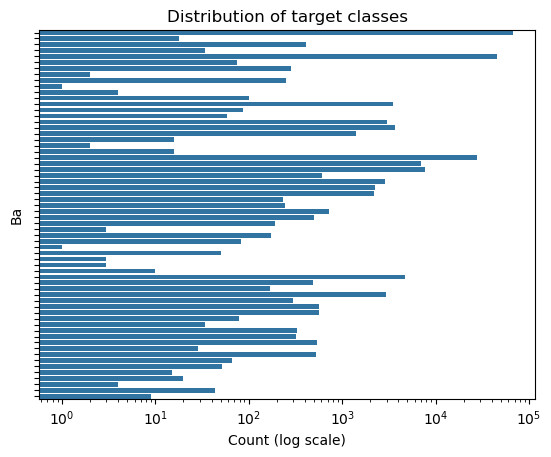

In [10]:
ax = sns.countplot(data=data_cop, y='Ba', orient='h')
plt.title('Distribution of target classes')
plt.xscale('log')
plt.xlabel('Count (log scale)')
ax.set_yticklabels([])
plt.show()

The dataset includes 357 trees that are marked as dead -> these trees will be removed. In addition, the target variable holding the species information consists
of 62 classes. These classes are highly imbalanced with some occurences < 10 instances. We will only train the classifiers to predict the 9 main tree species of which oak and maple are aggregated as one species (which is a common practice in forest science). 

### filter dead trees

In [11]:
# Filter dead trees 
data_cop = data[data['tot'] == 0]
data_cop.drop(columns=['tot'], inplace=True)

C:\Users\davha\AppData\Local\Temp\ipykernel_120528\2561581448.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cop.drop(columns=['tot'], inplace=True)


### select target species

In [12]:
# Select the main species 
species = [10, 20, 30, 40, 50, 100, 110, 111, 140, 141, 200]

# Transform oak and maple species into one category
data_cop.loc[data_cop['Ba'].isin([110, 111]), 'Ba'] = 110
data_cop.loc[data_cop['Ba'].isin([140, 141]), 'Ba'] = 140

# Only 9 target classes remaining
data_cop = data_cop[data_cop['Ba'].isin(species)]

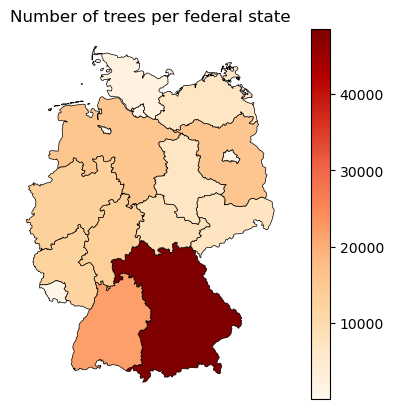

In [13]:
# Aggregate number of instaces per federal state and plot
n_trees_per_region = data_cop['bl'].value_counts()
regions = regions.join(n_trees_per_region, on='name', rsuffix='_trees')

ax = regions.plot(column='count', cmap='OrRd', legend=True, edgecolor='black', linewidth=0.5)
ax.set_axis_off()
plt.title('Number of trees per federal state')
plt.show()

The plot above shows the geographical distribution of instances aggregated on the federal state level (since the federal states are in charge of the implementation of the NFI and have changing underlying grid cell sizes). **These counts are before removing features and outliers which is done in the following.** 

## dataset preprocessing and EDA


### Exploration of NaN values in the dataset 

The dataset has custom NaN values for both numerical and categorical features. In the following these are replaced with Numpy NaNs. 

In [14]:
def replace_custom_NA_with_NaN(df, no_data_value, filter_type='any'):
    if isinstance(no_data_value, list):
        for value in no_data_value:
            df.replace(value, np.nan, inplace=True)
    else:
        df.replace(no_data_value, np.nan, inplace=True)

# Filter rows that contain no data for any feature
replace_custom_NA_with_NaN(data_cop, no_data_value=[-9999, -1], filter_type='any')

In [15]:
# Count NaN values per feature
def count_na_values(df, column):
    return df[column].isna().sum()

na_count = dict(zip(data_cop.columns, [count_na_values(data_cop, c) for c in data_cop.columns]))
na_count = pd.DataFrame(na_count.items(), columns=['Column', 'NA Count'])

na_feautures = na_count[na_count['NA Count'] > 0]

In [16]:
na_feautures

,Column,NA Count
9,D7,1397
19,Bhdst1,2
23,jSchael_x,169
26,Biov_o,169
27,Gexp,64858
28,GExpKl4,64888
29,GExpKl8,64858
30,Gform,4
34,potNatWg,4
40,NatNaeheHaupt,124


The features NatNaeheHaupt and NatNaeheLT7cm share similar information. We there remove the latter which holds the most NaN values (~90k). 	

In [17]:
data_cop.drop(columns='NatNaeheLT7cm', inplace=True)

In [18]:
nan_counts_by_bl = data_cop.groupby('bl').apply(lambda x: x.isna().any(axis=1).sum()).reset_index()
nan_counts_by_bl.columns = ['bl', 'nan_count']
regions = regions.join(nan_counts_by_bl.set_index('bl'), on='name')

C:\Users\davha\AppData\Local\Temp\ipykernel_120528\3962605439.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nan_counts_by_bl = data_cop.groupby('bl').apply(lambda x: x.isna().any(axis=1).sum()).reset_index()


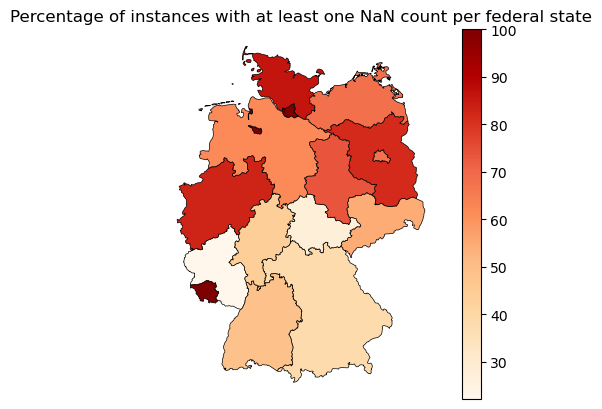

In [19]:
regions['nan_perc'] = regions['nan_count'] / regions['count'] * 100
ax = regions.plot(column='nan_perc', cmap='OrRd', legend=True, edgecolor='black', linewidth=0.5)
ax.set_axis_off()
plt.title('Percentage of instances with at least one NaN count per federal state')
plt.show()

The plot above shows the percentage of instances with at least one NaN value for each of the federal states. A 'hard removal' of all instances that with at least one NaN value would lead to an imbalance of instances. 
We would loose all instances from the city states Bremen, Hamburg and the smallest non-city state Saarland (which are not contributing much to the overall number of instances before NaN removing). In addition we would remove almost all instances from the northern states of Germany.  

C:\Users\davha\AppData\Local\Temp\ipykernel_120528\571961520.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nan_counts_by_bl = data_cop.groupby('bl').apply(lambda x: x.isna().sum())


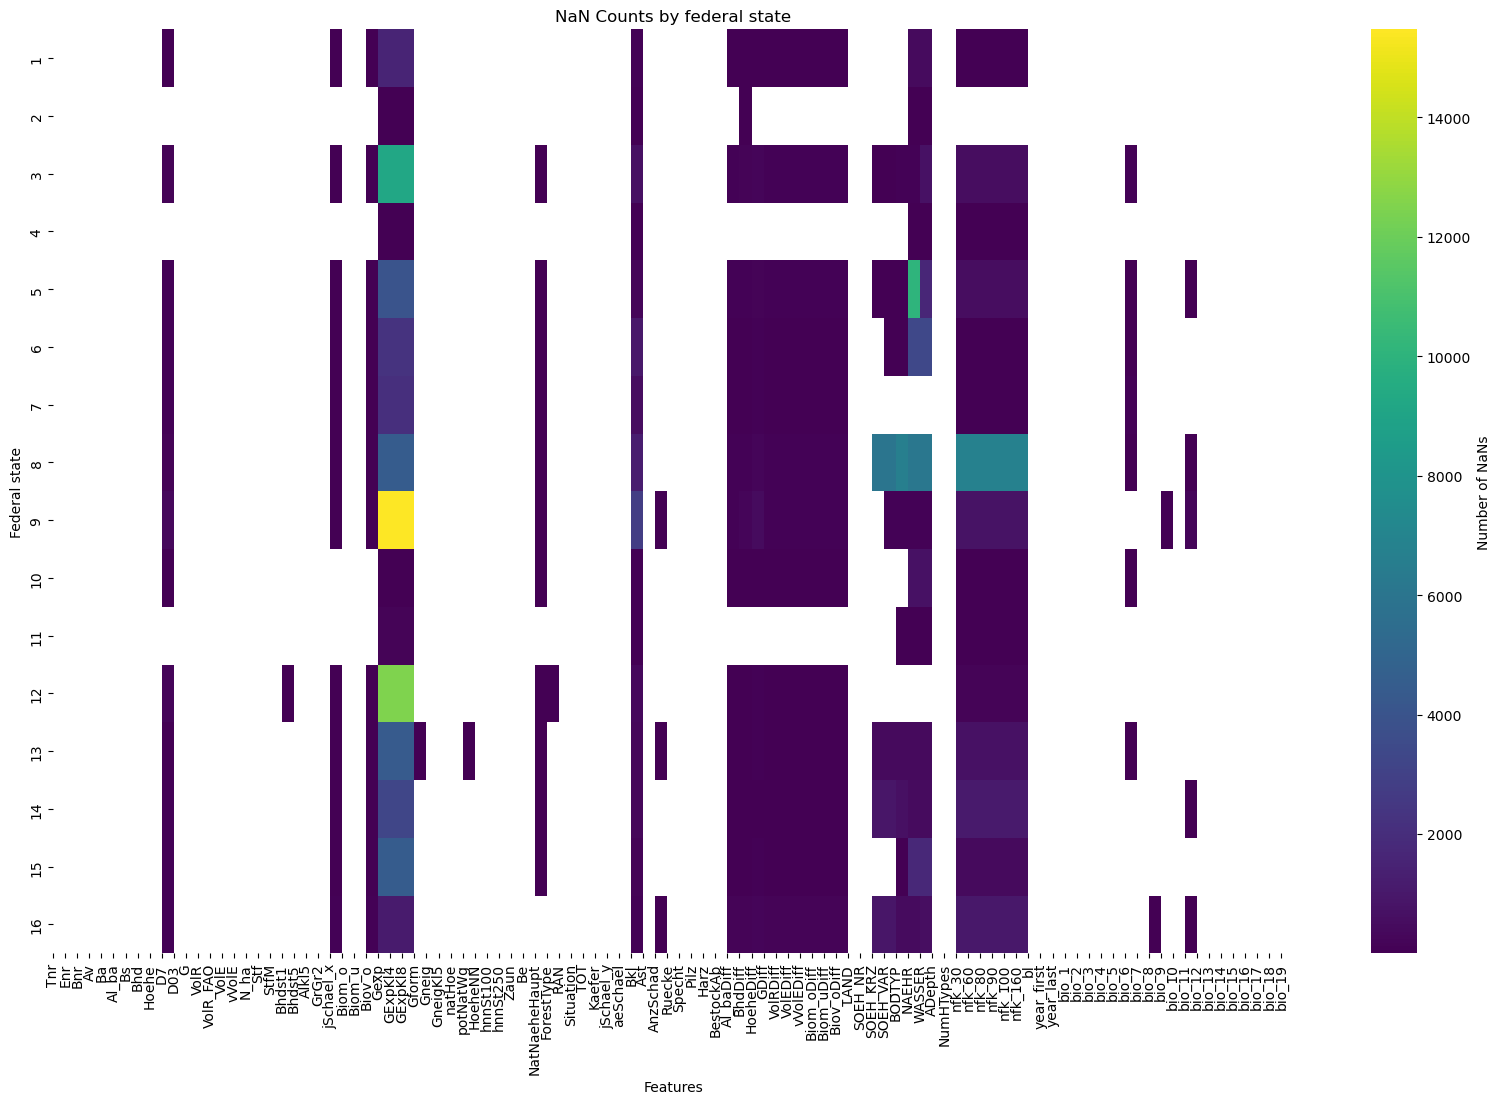

In [20]:
# Group by 'bl' and count NaNs
nan_counts_by_bl = data_cop.groupby('bl').apply(lambda x: x.isna().sum())
# Mask zero values
mask = nan_counts_by_bl == 0

# Create a heatmap
plt.figure(figsize=(20, 12))  # Increase the figure size for better visibility
ax = sns.heatmap(nan_counts_by_bl, cmap='viridis', cbar_kws={'label': 'Number of NaNs'}, mask=mask)
plt.title('NaN Counts by federal state')
plt.xlabel('Features')
plt.ylabel('Federal state')
plt.xticks(rotation=90)  # Rotate x-labels for better visibility

ax.set_xticks(np.arange(len(nan_counts_by_bl.columns)))
ax.set_xticklabels(nan_counts_by_bl.columns, rotation=90)

plt.show()

The plot above displays the features on x-axis and and the number of NaNs in the respective feature grouped by the federal states on the y-axis. We can observe that the NaN values are grouped (e.g. 'nfk' or 'diff' features). Based on the plot, the overall aim of the dataset and further exploration of the respecitve features we select features for the final dataset that is used for training different classifiers. 

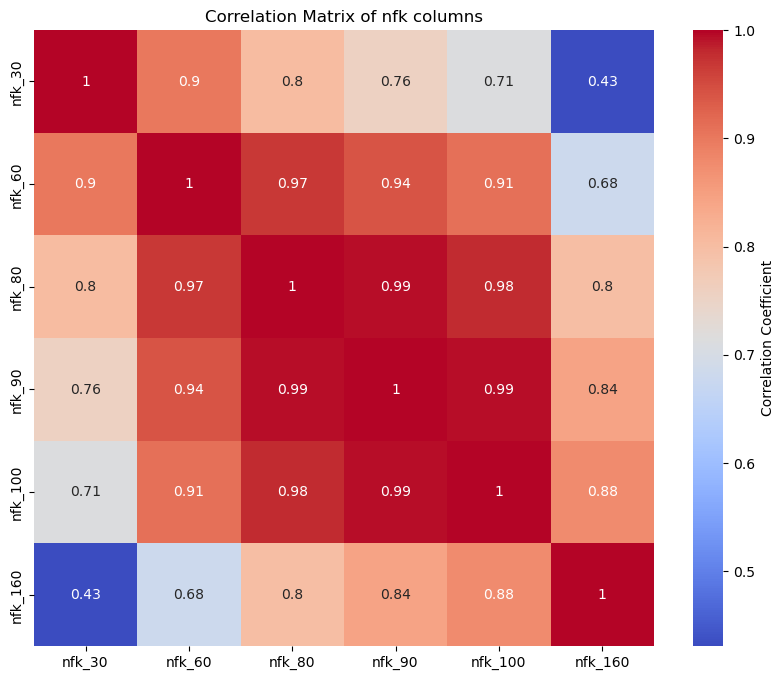

In [21]:
nfk_columns = [col for col in data_cop.columns if col.startswith('nfk')]
nfk_data = data_cop[nfk_columns]

corr_matrix = nfk_data.corr()

plt.figure(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of nfk columns')
plt.show()

The nfk features describe the water storage capacity of the given soil in different depth (0-30, 30-60, ...). Since the features are moderate to highly correlated we only use the nfk_30 feauture in the final dataset.

In [22]:
# Remove nfk classes 
cols_to_remove = [
    'nfk_60',
    'nfk_80',
    'nfk_90',
    'nfk_100',
    'nfk_160'
]

data_cop.drop(columns=cols_to_remove, inplace=True)

Since we are dealing with a classification task on a 'single' inventory time instance (with measurements taking over a period of time) and not a growth prediction task, we remove all features that hold the differential information of the two inventory periods. 

In [23]:
# Remove differential columns 
cols_to_remove = [
    'BhdDiff',
    'HoeheDiff',
    'GDiff',
    'VolRDiff',
    'VolEDiff',
    'vVolEDiff',
    'Biom_oDiff',
    'Biom_uDiff',
    'Biov_oDiff',
    'Al_baDiff'
]

data_cop.drop(columns=cols_to_remove, inplace=True)

To further reduce the number of features we remove categorical features that hold the same information as their numerical counterparts. In other words, features that are binned using the numerical features (exposition classes, slope classes). 

In [24]:
# Remove categorical counterparts to already existing numerical columns
cols_to_remove = [
   'GExpKl4',
   'GExpKl8',
   'GneigKl5',
   'Bhdst1',
   'Bhdst5',
   'Alkl5',
   'hnnSt100',
   'hnnSt250',
]

data_cop.drop(columns=cols_to_remove, inplace=True)

We further remove the features that hold database foreign key or date information (and bl for plotting). Except for Tnr and Enr which are used for grouping and stratified cross-validation. 

In [25]:
cols_to_remove = [
   'Bnr',
   'year_first',
   'year_last'
]

data_cop.drop(columns=cols_to_remove, inplace=True)

In [204]:
data_cop.shape

(172356, 77)

In [205]:
data_cop['Av'].unique()

array([0])

The 'Av' feature indicates how a single tree has been taken into account in the inventory. All instances are measured while conducting a angle count sampling. Since this is the same for every instance, we remove this feature.

In [206]:
data_cop.drop(columns='Av', inplace=True)

In the following we remove all features that are not relevant to a classification task 
that could possibly be conducted using derived features from remote sensing or 
EO data. And/Or hold same information as already existing features. 

In [26]:
cols_to_remove = [
   'jSchael_x', # Yes/No on bark damage due to game
   'VolR_FAO', # FAO specific volume calculation 
   'VolE', # Volume of the tree without bark
   'vVolE', # usable bolume of the tree without bark in 
   'StfM', # normalized standing area per ha for the given tree
   'Biom_u',  # below ground biomass -> not available from RS/EO data
   'Zaun', # Yes/No on fence around the tree
   'ForestType', # Includes the main species and is therefore logical not relevant in the datset
   'RAN',  # Tnr, Enr based feature counting the number of non-forest edges in the grid
   'Kaefer', # Yes/No on bark beetle infestation
   'jSchael_y', # redundant jSchael_x 
   'aeSchael', # Yes/No on bark damage due to game
   'AnzSchad', # Numer of damages on the tree
   'Ruecke', # Yes/No damage on the tree due to logging
   'Specht', # Yes/No on woodpecker holes
   'Pilz', # Yes/No on fungus on the tree
   'Harz', # Yes/No on resin on the tree
   'LAND', # federal state (redundant to bl)
   'SOEH_NR', # soil profile key for the soil type
   'SOEH_KRZ', # soil profile key for the soil type
   'SOEH_VAR', # soil profile key for the soil type
   'ADepth', # depth of the A horizon -> not available from RS/EO data
   'NumHTypes', # numy of different horzon types in the soil profile -> not available from RS/EO data
   'potNatWg', # forest families that mostly named by the tree species used as target
   'GrGr2', # categorical feature combining heght and dbh 
]

In [27]:
data_cop.drop(columns=cols_to_remove, inplace=True)

In [28]:
df_nans = data_cop[data_cop.isna().any(axis=1)]
df_nans.shape

(88448, 52)

Total number of possible hard dropped NaNs = 88448

In [29]:

nan_counts_by_bl = df_nans['bl'].value_counts()
regions = regions.join(nan_counts_by_bl, on='name', rsuffix='_nan_count')

In [30]:
nan_perc_by_bl = df_nans['bl'].value_counts() / data_cop['bl'].value_counts() * 100
regions = regions.join(nan_perc_by_bl, on='name', rsuffix='_nan_perc')

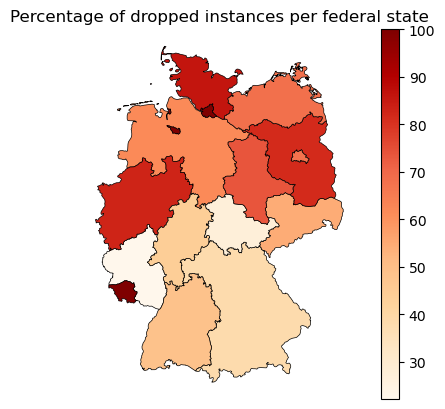

In [31]:
ax = regions.plot(column='nan_perc', cmap='OrRd', legend=True, edgecolor='black', linewidth=0.5)
ax.set_axis_off()
plt.title('Percentage of dropped instances per federal state')
plt.show()

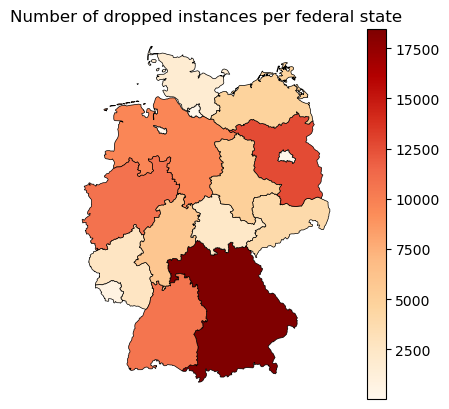

In [32]:

ax = regions.plot(column='nan_count', cmap='OrRd', legend=True, edgecolor='black', linewidth=0.5)
ax.set_axis_off()
plt.title('Number of dropped instances per federal state')
plt.show()

In [33]:
perc_dropped_nan_per_species = df_nans['Ba'].value_counts() / data_cop['Ba'].value_counts() * 100

In [34]:

index_as_list = perc_dropped_nan_per_species.index.astype(str).tolist()
modified_index = [config['Ba'].get(item, item) for item in index_as_list]
perc_dropped_nan_per_species.index = modified_index

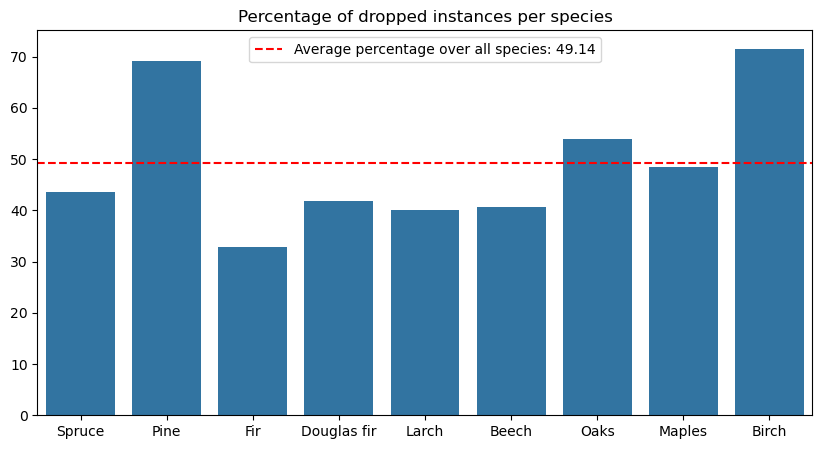

In [35]:
# Barplot of percentage of dropped species 
plt.figure(figsize=(10, 5))
sns.barplot(x=perc_dropped_nan_per_species.index, y=perc_dropped_nan_per_species.values)
plt.axhline(perc_dropped_nan_per_species.mean(), color='red', linestyle='--',
            label=f'Average percentage over all species: {perc_dropped_nan_per_species.mean():.2f}')
plt.title('Percentage of dropped instances per species')
plt.xlabel('')
plt.legend()
plt.show()

In [36]:
print(data_cop.isna().sum())

Tnr                  0
Enr                  0
Av                   0
Ba                   0
Al_ba                0
Bs                   0
Bhd                  0
Hoehe                0
D7                1397
D03                  0
G                    0
VolR                 0
N_ha                 0
Stf                  0
Biom_o               0
Biov_o             169
Gexp             64858
Gform                4
Gneig                0
natHoe               0
HoeheNN              0
Be                   0
NatNaeheHaupt      124
Situation            0
TOT                  0
Bkl               7668
Ast                  0
BestockAb            0
BODTYP            8419
NAEHR            23879
WASSER           16258
nfk_30           11953
bl                   0
bio_1                0
bio_2                0
bio_3                0
bio_4                0
bio_5                0
bio_6              315
bio_7                0
bio_8               11
bio_9               38
bio_10               0
bio_11     

In [37]:
bkl_nans_sp = df_nans[df_nans['Bkl'].isna()].groupby('Ba').size()
naheHaupt_nans_sp = df_nans[df_nans['NatNaeheHaupt'].isna()].groupby('Ba').size()
bodtyp_nans_sp = df_nans[df_nans['BODTYP'].isna()].groupby('Ba').size()
naehr_nans_sp = df_nans[df_nans['NAEHR'].isna()].groupby('Ba').size()
wasser_nans_sp = df_nans[df_nans['WASSER'].isna()].groupby('Ba').size()
nfk_nans_sp = df_nans[df_nans['nfk_30'].isna()].groupby('Ba').size()

nan_series_list = [bkl_nans_sp, naheHaupt_nans_sp, bodtyp_nans_sp, naehr_nans_sp, wasser_nans_sp, nfk_nans_sp]
for nan_series in nan_series_list:
    index_as_list = nan_series.index.astype(str).tolist()
    modified_index = [config['Ba'].get(item, item) for item in index_as_list]
    nan_series.index = modified_index

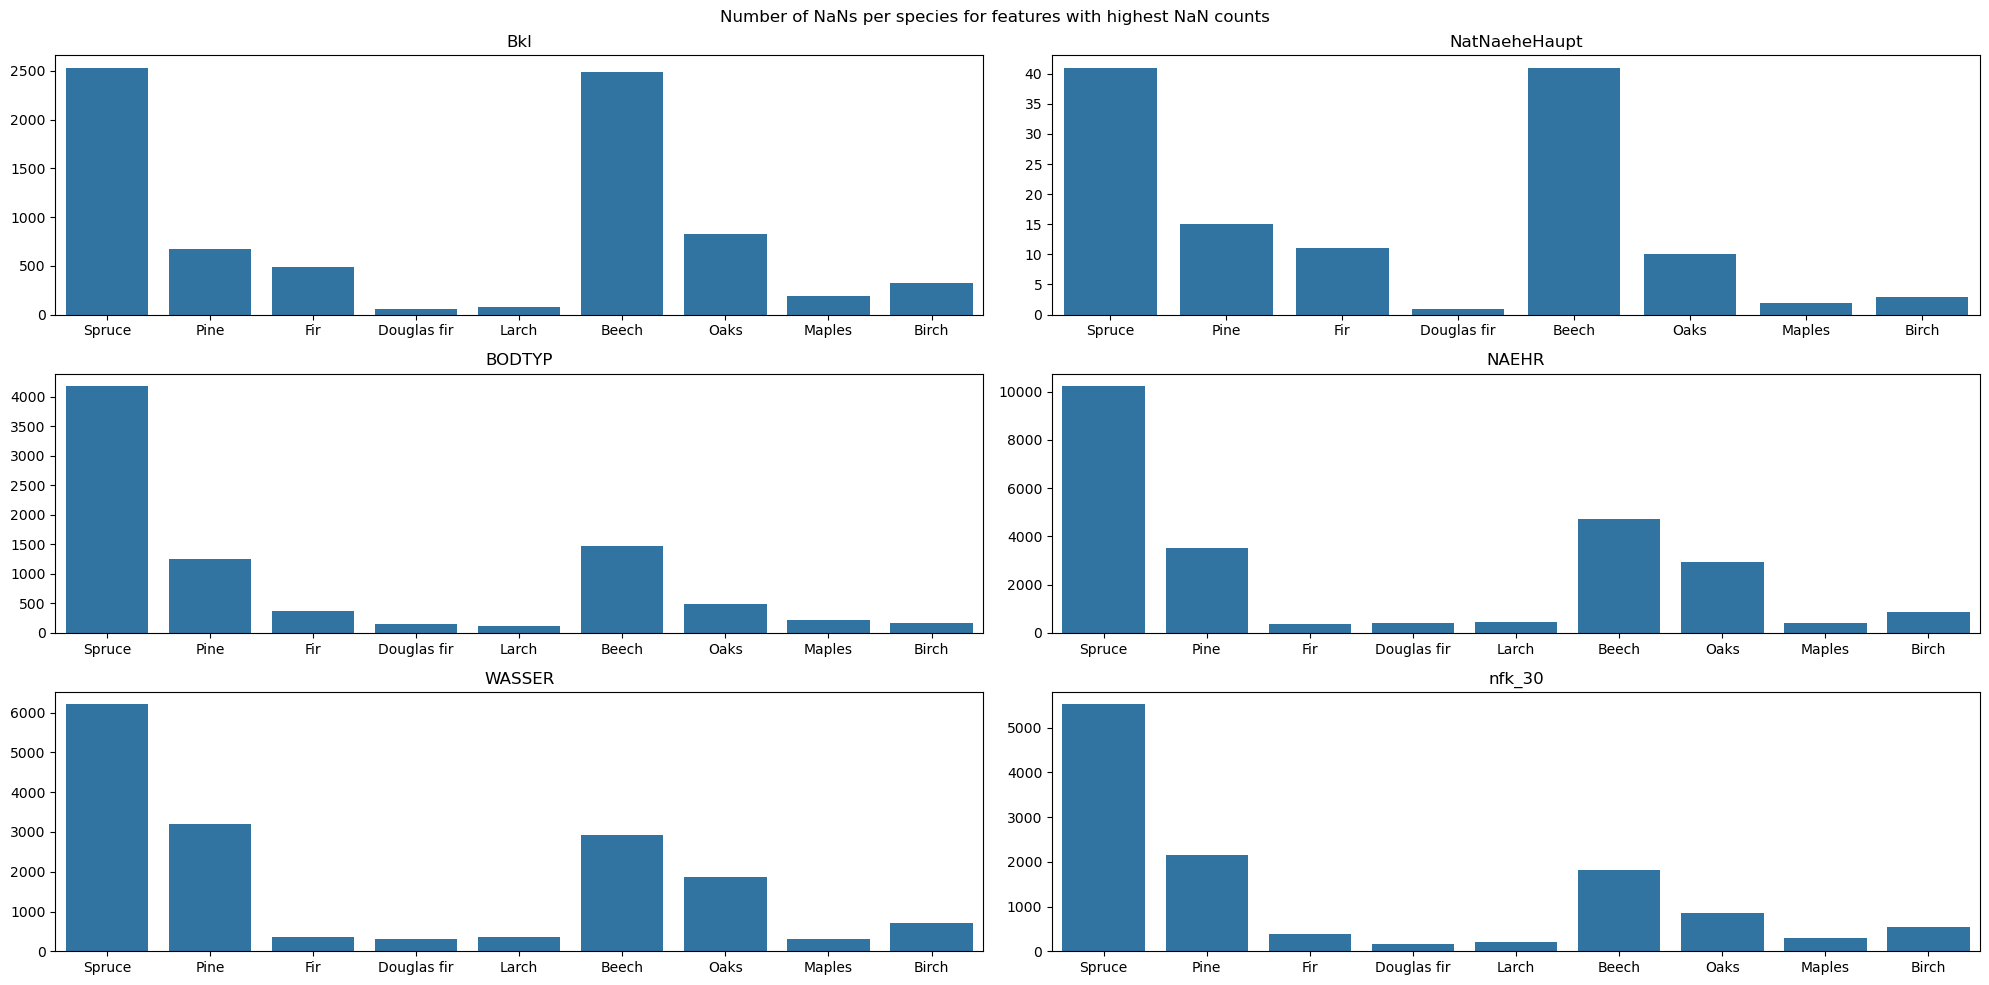

In [246]:
fig, axs = plt.subplots(3, 2, figsize=(20, 10))

sns.barplot(x=bkl_nans_sp.index, y=bkl_nans_sp.values, ax=axs[0, 0])
axs[0, 0].set_title('Bkl')
axs[0, 0].set_xlabel('')
sns.barplot(x=naheHaupt_nans_sp.index, y=naheHaupt_nans_sp.values, ax=axs[0, 1])
axs[0, 1].set_title('NatNaeheHaupt')
axs[0, 1].set_xlabel('')
sns.barplot(x=bodtyp_nans_sp.index, y=bodtyp_nans_sp.values, ax=axs[1, 0])
axs[1, 0].set_title('BODTYP')
axs[1, 0].set_xlabel('')
sns.barplot(x=naehr_nans_sp.index, y=naehr_nans_sp.values, ax=axs[1, 1])
axs[1, 1].set_title('NAEHR')
axs[1, 1].set_xlabel('')
sns.barplot(x=wasser_nans_sp.index, y=wasser_nans_sp.values, ax=axs[2, 0])
axs[2, 0].set_title('WASSER')
axs[2, 0].set_xlabel('')
sns.barplot(x=nfk_nans_sp.index, y=nfk_nans_sp.values, ax=axs[2, 1])
axs[2, 1].set_title('nfk_30')
axs[2, 1].set_xlabel('')

fig.suptitle('Number of NaNs per species for features with highest NaN counts')
plt.tight_layout()
plt.show()

In [38]:
data_cop['Bkl'].astype(str).rename(config['Bkl'])

0         3.0
1         2.0
2         1.0
3         1.0
4         1.0
         ... 
190268    2.0
190269    2.0
190270    3.0
190271    2.0
190272    3.0
Name: Bkl, Length: 172356, dtype: object

After this manual preselection of features we remove all NaN values. 

In [39]:
data_cop.dropna(inplace=True)
print(data_cop.isna().sum())

Tnr              0
Enr              0
Av               0
Ba               0
Al_ba            0
Bs               0
Bhd              0
Hoehe            0
D7               0
D03              0
G                0
VolR             0
N_ha             0
Stf              0
Biom_o           0
Biov_o           0
Gexp             0
Gform            0
Gneig            0
natHoe           0
HoeheNN          0
Be               0
NatNaeheHaupt    0
Situation        0
TOT              0
Bkl              0
Ast              0
BestockAb        0
BODTYP           0
NAEHR            0
WASSER           0
nfk_30           0
bl               0
bio_1            0
bio_2            0
bio_3            0
bio_4            0
bio_5            0
bio_6            0
bio_7            0
bio_8            0
bio_9            0
bio_10           0
bio_11           0
bio_12           0
bio_13           0
bio_14           0
bio_15           0
bio_16           0
bio_17           0
bio_18           0
bio_19           0
dtype: int64

In [40]:
data_cop.shape

(83908, 52)

In [41]:
print(f" Number of unique soil type categories is: {data_cop['BODTYP'].unique().shape[0]}")
print(f" Number of unique water supply categories is: {data_cop['WASSER'].unique().shape[0]}")

 Number of unique soil type categories is: 246
 Number of unique water supply categories is: 29


To prevent too many features when performing onehot-encoding on the categorical features, we reduce the BODTYP and WASSER categories in the following.  

In **soil type** descriptions captial letters refer to the main soil horizon/soil types. The first capital letter is the most prominent type for the whole soil. Therefore, we find the first capital letter in the category strings and reassign the value of the instance. 

Similarly we select only the capital letter for the WASSER feature, since there are only four main classifications for the impact of water on the given soil present. The numerical part is a finer classification level, that we omit for the reasons stated above. 

In [42]:
import re
# Change soil type column to reduce number of categories
data_cop['BODTYP'] = data_cop['BODTYP'].apply(lambda x: re.findall(r'[A-Z]+', str(x)))
data_cop['BODTYP'] = data_cop['BODTYP'].apply(lambda x: x[0][0] if x else None)

In [43]:
# Change water column to reduce number of categories
data_cop['WASSER'] = data_cop['WASSER'].apply(lambda x: x[0] if isinstance(x, str) else x)

In [44]:
print(f" Number of unique soil type categories is: {data_cop['BODTYP'].unique().shape[0]}")
print(f" Number of unique water supply categories is: {data_cop['WASSER'].unique().shape[0]}")

 Number of unique soil type categories is: 13
 Number of unique water supply categories is: 3


Like this we achieve a reduction of the aforementionted features to more reasonable number of classes. 

Next we ensure that all categorical column values are converted to strings in order to replace based on the config file. 

In [45]:
# Change Gform, natHoe, NatNaeheHaupt, Bkl, NAEHR to str without x.0
for col in ['Gform', 'natHoe', 'NatNaeheHaupt', 'Bkl', 'NAEHR']:
    data_cop[col] = data_cop[col].astype(float).astype(int).astype(str)

In [46]:
categorical_features = [key for key in config.keys()]

In [47]:
categorical_features.remove('BODTYP')
categorical_features.remove('WASSER')
categorical_features.remove('Ba')

In [48]:
categorical_features

['Ast',
 'Be',
 'BestockAb',
 'Bkl',
 'Bs',
 'Gform',
 'natHoe',
 'NatNaeheHaupt',
 'Situation',
 'NAEHR']

In [49]:
for feature in categorical_features:
    data_cop[feature] = data_cop[feature].astype(str)


In [50]:
# Change values based on key-value pairs in the config file 
for key in config.keys():
    data_cop[key] = data_cop[key].astype(str).replace(config[key])

In [51]:
data_cop.shape

(83908, 52)

In [52]:
data_cop['Ba'].value_counts()

Ba
Spruce         37717
Beech          16426
Pine           14069
Oaks            6762
Fir             2368
Larch           2205
Douglas fir     1773
Birch           1341
Maples          1247
Name: count, dtype: int64

### Target class distribution

In [ ]:
grouped_df = data_cop.groupby('bl')['Ba'].value_counts().unstack().fillna(0)

grouped_df['sum_trees'] = grouped_df.sum(axis=1)

for col in data_cop['Ba'].unique():
    grouped_df[(col+'_perc')] = grouped_df[col] / grouped_df['sum_trees']

In [54]:
grouped_df

Ba,Beech,Birch,Douglas fir,Fir,Larch,Maples,Oaks,Pine,Spruce,sum_trees,Spruce_perc,Maples_perc,Beech_perc,Fir_perc,Pine_perc,Larch_perc,Birch_perc,Oaks_perc,Douglas fir_perc
bl,,,,,,,,,,,,,,,,,,,
1,114.0,5.0,1.0,0.0,4.0,10.0,62.0,4.0,89.0,289.0,0.307958,0.034602,0.394464,0.000000,0.013841,0.013841,0.017301,0.214533,0.003460
3,1868.0,101.0,105.0,6.0,225.0,114.0,361.0,841.0,2424.0,6045.0,0.400993,0.018859,0.309016,0.000993,0.139123,0.037221,0.016708,0.059719,0.017370
5,461.0,62.0,30.0,0.0,82.0,23.0,218.0,68.0,1351.0,2295.0,0.588671,0.010022,0.200871,0.000000,0.029630,0.035730,0.027015,0.094989,0.013072
6,2487.0,61.0,234.0,0.0,422.0,87.0,848.0,721.0,2616.0,7476.0,0.349920,0.011637,0.332665,0.000000,0.096442,0.056447,0.008159,0.113430,0.031300
7,2288.0,170.0,682.0,24.0,202.0,133.0,2054.0,1303.0,2642.0,9498.0,0.278164,0.014003,0.240893,0.002527,0.137187,0.021268,0.017899,0.216256,0.071805
8,2378.0,20.0,451.0,1365.0,169.0,253.0,571.0,842.0,5227.0,11276.0,0.463551,0.022437,0.210890,0.121054,0.074672,0.014988,0.001774,0.050639,0.039996
9,4410.0,357.0,155.0,965.0,565.0,402.0,1494.0,5257.0,16783.0,30388.0,0.552290,0.013229,0.145123,0.031756,0.172996,0.018593,0.011748,0.049164,0.005101
11,10.0,13.0,0.0,0.0,2.0,0.0,22.0,35.0,0.0,82.0,0.000000,0.000000,0.121951,0.000000,0.426829,0.024390,0.158537,0.268293,0.000000
12,231.0,131.0,27.0,0.0,20.0,14.0,221.0,2128.0,81.0,2853.0,0.028391,0.004907,0.080967,0.000000,0.745882,0.007010,0.045917,0.077462,0.009464


In [55]:
# merge region data with grouped_df
regions = regions.join(grouped_df, on='name')

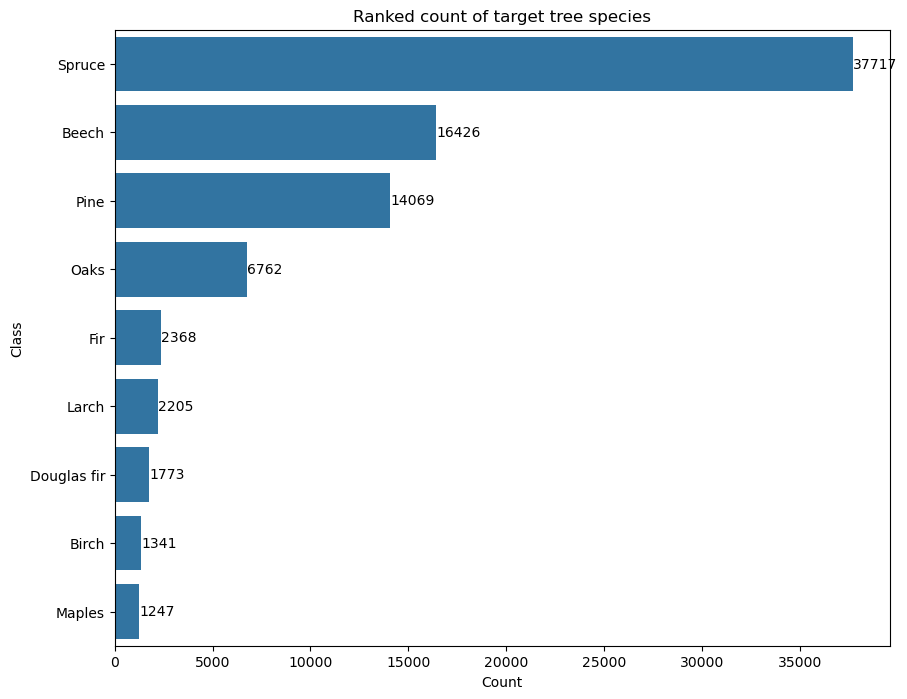

In [56]:
species_counts = data_cop['Ba'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 8))
ax = sns.barplot(y=species_counts.index, x=species_counts.values, orient='h')
plt.title('Ranked count of target tree species')
plt.xlabel('Count')
plt.ylabel('Class')

# Add annotations
for i in range(len(species_counts)):
    ax.text(species_counts.values[i], i, f'{species_counts.values[i]}', va='center')

plt.show()

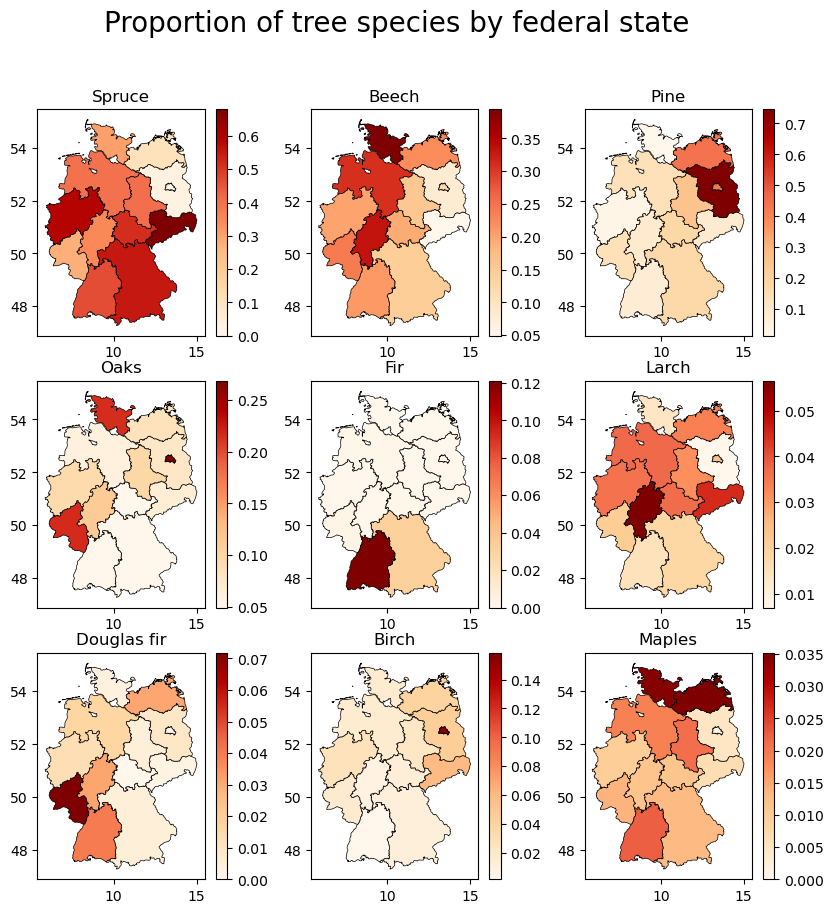

In [57]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10)) # Create a 3x3 grid of subplots
fig.suptitle('Proportion of tree species by federal state', fontsize=20)

ba_sorted_asc = data_cop['Ba'].value_counts().sort_values(ascending=False).index
for i, col_name in enumerate(ba_sorted_asc):
    ax = regions.plot(column=(col_name+'_perc'), cmap='OrRd', legend=True, edgecolor='black', linewidth=0.5, ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(col_name)
    
plt.show()

We can see that spruce and beeches are the most prominent species for almost all federal states in the dataset. Pines are especially dominant in Brandenburg. The other tree species with relatively less instances in the dataset only share small proportions and are more or less dominant in specific federal states. Even though the input data (see graph at the beginning) is not distributed equally by the federal states, the dataset reflects the geographical distribution of the tree species quite good. 

### EDA of features

In [58]:
data_cop.to_csv('../datasets/ml_bwi_v3.csv', index=False)

In [59]:
group_features = data_cop[['Tnr', 'Enr', 'bl']]
target = data_cop['Ba']
features = data_cop.drop(columns=['Tnr', 'Enr', 'bl', 'Ba'], inplace=False)

In [60]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83908 entries, 0 to 190272
Data columns (total 48 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Av             83908 non-null  int64  
 1   Al_ba          83908 non-null  float64
 2   Bs             83908 non-null  object 
 3   Bhd            83908 non-null  int64  
 4   Hoehe          83908 non-null  float64
 5   D7             83908 non-null  float64
 6   D03            83908 non-null  float64
 7   G              83908 non-null  float64
 8   VolR           83908 non-null  float64
 9   N_ha           83908 non-null  float64
 10  Stf            83908 non-null  float64
 11  Biom_o         83908 non-null  float64
 12  Biov_o         83908 non-null  float64
 13  Gexp           83908 non-null  float64
 14  Gform          83908 non-null  object 
 15  Gneig          83908 non-null  int64  
 16  natHoe         83908 non-null  object 
 17  HoeheNN        83908 non-null  int64  
 18  Be        

After the new selection of features 47 remain in the dataset. In the following we conduct further EDA.

In [61]:
numerical_features = features.select_dtypes(include=[np.number])
categorical_features = features.select_dtypes(include='object')

print(f"Number of numerical features: {numerical_features.shape[1]}")
print(f"Number of categorical features: {categorical_features.shape[1]}")

Number of numerical features: 36
Number of categorical features: 12


In [62]:
numerical_features.describe()

,Av,Al_ba,Bhd,Hoehe,D7,D03,G,VolR,N_ha,Stf,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
count,83908.0,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,...,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000,83908.000000
mean,0.0,81.871300,347.982767,249.740680,275.596356,273.439887,0.111864,1.484027,82.319596,31.261505,...,16.271566,0.335085,972.510416,116.702746,54.915086,0.222919,304.787565,192.029187,282.201101,231.335272
std,0.0,38.537804,146.075933,69.119282,124.398566,113.347410,0.095911,1.611220,107.862968,27.854572,...,1.271723,1.176390,352.053669,46.202829,19.116226,0.061556,121.306306,69.203378,117.711205,90.982075
min,0.0,9.000000,70.000000,70.000000,0.000000,50.000000,0.003848,0.005248,0.000000,2.154535,...,10.240000,-4.550000,482.000000,51.000000,26.000000,0.090000,144.000000,91.000000,135.000000,91.000000
25%,0.0,50.000000,242.000000,202.000000,186.000000,192.000000,0.045996,0.444078,27.917514,13.596768,...,15.540000,-0.380000,751.000000,89.000000,42.000000,0.180000,230.000000,145.000000,212.000000,165.000000
50%,0.0,79.000000,333.000000,252.000000,265.000000,262.000000,0.087092,1.007300,47.052025,23.816597,...,16.480000,0.400000,870.000000,105.000000,50.000000,0.210000,272.000000,175.000000,251.000000,207.000000
75%,0.0,105.000000,435.000000,299.000000,352.000000,339.000000,0.148617,1.960009,88.419418,39.456863,...,17.170000,1.190000,1074.000000,127.000000,63.000000,0.260000,332.000000,216.000000,302.000000,274.000000
max,0.0,316.000000,1598.000000,525.000000,1237.000000,1286.000000,2.005596,48.329384,1194.253540,666.029541,...,19.880000,3.840000,3252.000000,396.000000,202.000000,0.490000,1042.000000,704.000000,1042.000000,710.000000


In [1]:

# Create a boxplot for each numerical feature
plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=numerical_features, orient='h')
ax.set_xscale('log')
plt.title('Boxplot of Numerical Features with Log-Scaled X-Axis (limited to [0, 10e5])')
plt.xlabel('Value (log scale)')
plt.xlim(0, 10e5)
plt.ylabel('Features')
plt.show()

NameError: name 'plt' is not defined

**Note on outliers** We assume that the quality control of NFI has removed possible outliers before publishing the dataset. Given this, the boxplots above show for example the natural variability of numerical tree parameters due to the different phenology of the species - the biomass of a beech with 60 cm diameter at breast height (dbh) can be much greater compared to a spruce with the same dbh. 

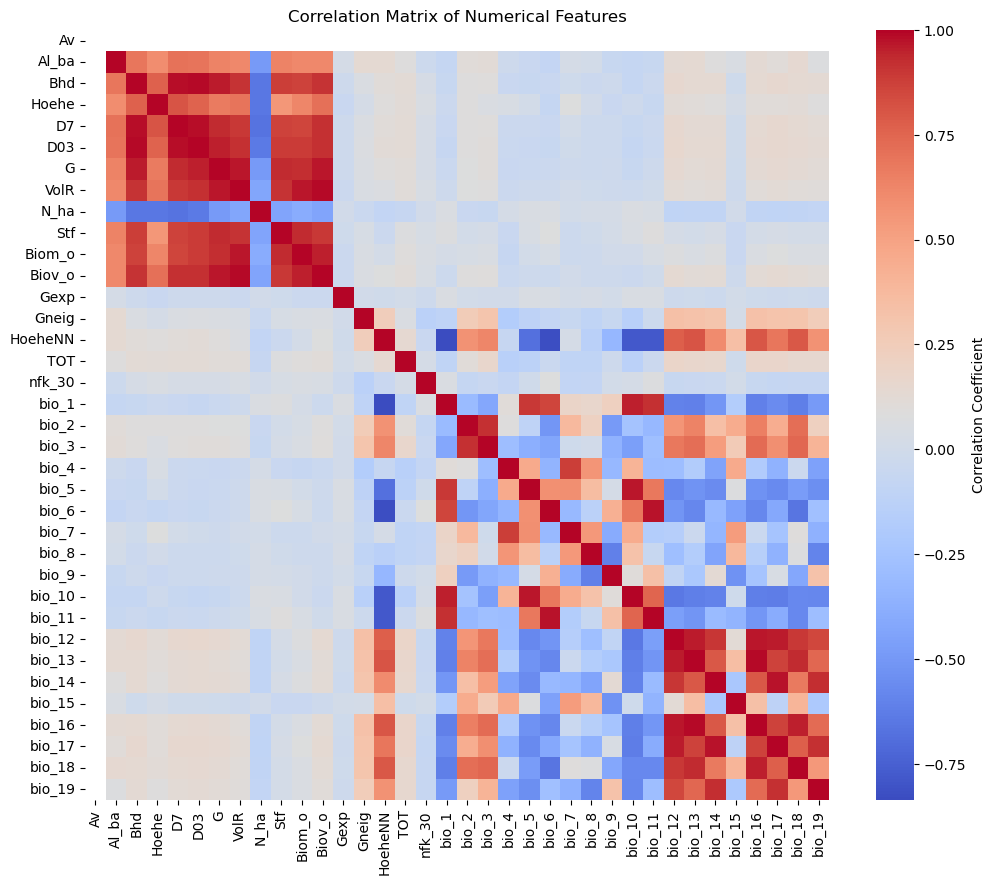

In [64]:
corr_matrix = numerical_features.corr()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(corr_matrix, cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Numerical Features')
plt.show()

The correlation plot indicates correlation within the group of climate and geographical exposition features and the group features that describe the shape of the trees (height, dbh, biomass, ...). The observed correlations are reasonable. However, as suggested, we will perform a PCA on the numerical features to see if we can reduce the number of numerical features. 

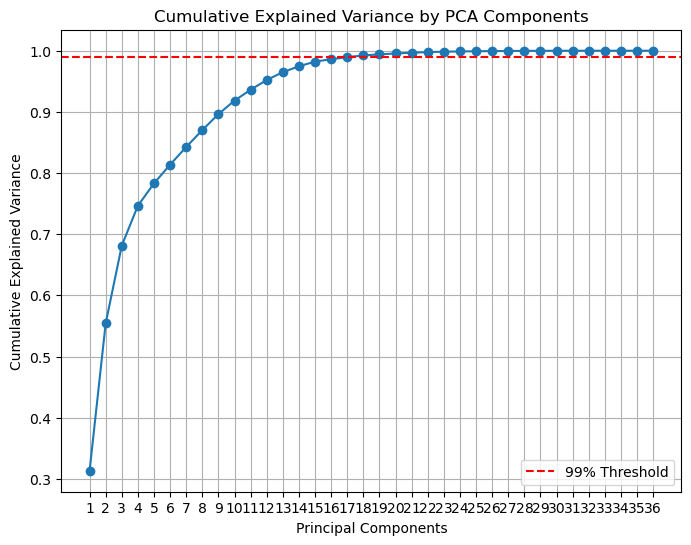

In [65]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features)


pca = PCA(n_components=numerical_features.shape[1]) # set n_components to the number of features (< number of instances)
principal_components = pca.fit_transform(scaled_features)

exp_var = pca.explained_variance_ratio_


cumulative_variance = np.cumsum(exp_var)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.99, color='r', linestyle='--', label='99% Threshold')
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.grid()
plt.legend()
plt.show()

In [66]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features)


pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)


pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])


In [67]:
pca_df['Ba'] = target.values

<Axes: xlabel='PC1', ylabel='PC2'>

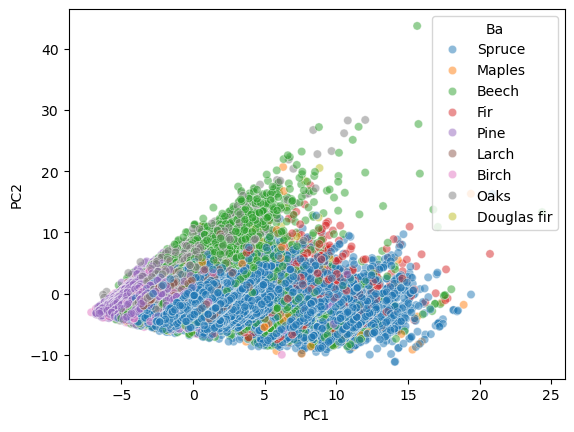

In [68]:
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Ba', alpha=0.5)



In [79]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features)

In [78]:
numerical_features.drop(columns='Av', inplace=True)

In [81]:
pca = PCA(n_components=numerical_features.shape[1])

In [82]:
pca.fit(scaled_features)

PCA(n_components=35)

In [83]:
pca.components_

array([[ 1.22554926e-01,  1.52954737e-01,  1.20776844e-01, ...,
         2.49070416e-01,  2.51012520e-01,  2.14395421e-01],
       [ 2.09298504e-01,  2.88479314e-01,  2.32423596e-01, ...,
        -1.04368843e-01, -1.14211311e-01, -9.24221687e-02],
       [ 3.21776927e-02,  4.28494202e-03,  3.89426765e-02, ...,
        -1.32770100e-01,  1.28762226e-01, -2.34720614e-01],
       ...,
       [-3.42547043e-04,  7.56131466e-03, -9.36112639e-04, ...,
         1.31014857e-02, -4.44766150e-02, -1.68987441e-02],
       [ 6.95197591e-04,  1.43354856e-03, -1.16143934e-03, ...,
         6.86474729e-04,  1.42261507e-02, -4.22596061e-03],
       [-0.00000000e+00,  3.54115192e-14, -2.10430020e-16, ...,
        -5.35882097e-16,  3.14786808e-14,  1.97188511e-15]])

In [165]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(scaled_features)

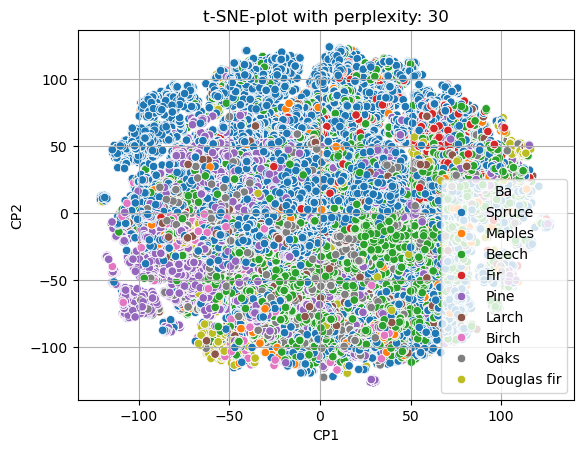

In [173]:
tsne_df = pd.DataFrame(tsne_result, columns=['CP1', 'CP2'])
tsne_df['Ba'] = target.values

sns.scatterplot(data=tsne_df, x='CP1', y='CP2', hue='Ba')
plt.title('t-SNE-plot with perplexity: 30')
plt.xlabel('CP1')
plt.ylabel('CP2')
plt.grid()

As can be seen above, the PCA allows as to reduce the numerical features by circa the half while still explaining 99% of the variance in the dataset. 

In [58]:
categorical_features.describe()

,Bs,Gform,natHoe,Be,NatNaeheHaupt,Situation,Bkl,Ast,BestockAb,BODTYP,NAEHR,WASSER
count,83908,83908,83908,83908,83908,83908,83908,83908,83908,83908,83908,83908
unique,1,10,5,3,5,7,4,4,6,13,6,3
top,main stand,middle sloping site,submontane,even-aged high forest,conditional seminaturel,none,dominant tree,no pruning,single storied,B,mesotrophic,T
freq,83908,25994,36108,83541,27119,81771,52137,81710,37720,59941,25271,75213


From the description of the categorical features we can see that the *Bs* feature is the same for all instances, thus we will remove the feature since it does not explain any variance in the dataset. By further checking the features we can see that the most frequent category for the features *Be*, *Situation*, *Ast* and *WASSER* account for almost the entire feature distribution. We therefore plot these features in the following to further investigate them. 

In [59]:
def plot_categorical_feature(data, feature, sharey=False, col_wrap=3):
    feature_ba_counts = data_cop.groupby(feature)['Ba'].value_counts().reset_index(name='Count')
    class_order = data_cop['Ba'].unique()
    
    fig = sns.catplot(
        data=feature_ba_counts, 
        x='Ba', y='Count', 
        col=feature,
        hue='Ba',
        kind='bar', 
        col_wrap=col_wrap, 
        height=4, 
        aspect=1.2, 
        sharey=sharey,
        order=class_order,  # Specify the order of the classes
        legend=True
    )
    fig.set_xticklabels([])
    fig.legend.set_title('Species')
    plt.show()


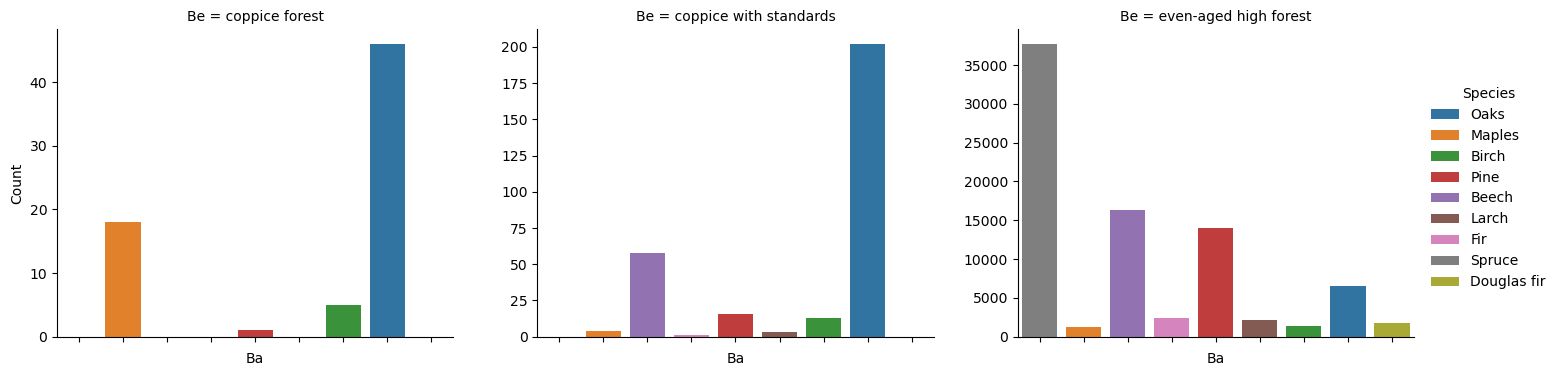

In [60]:
plot_categorical_feature(data_cop, 'Be')

Even though the most instances come from even-aged high forests, we can see that the feature might help in mitigating the less prominent tree species which are very common in coppice forests. We therefore include the feature in the dataset.

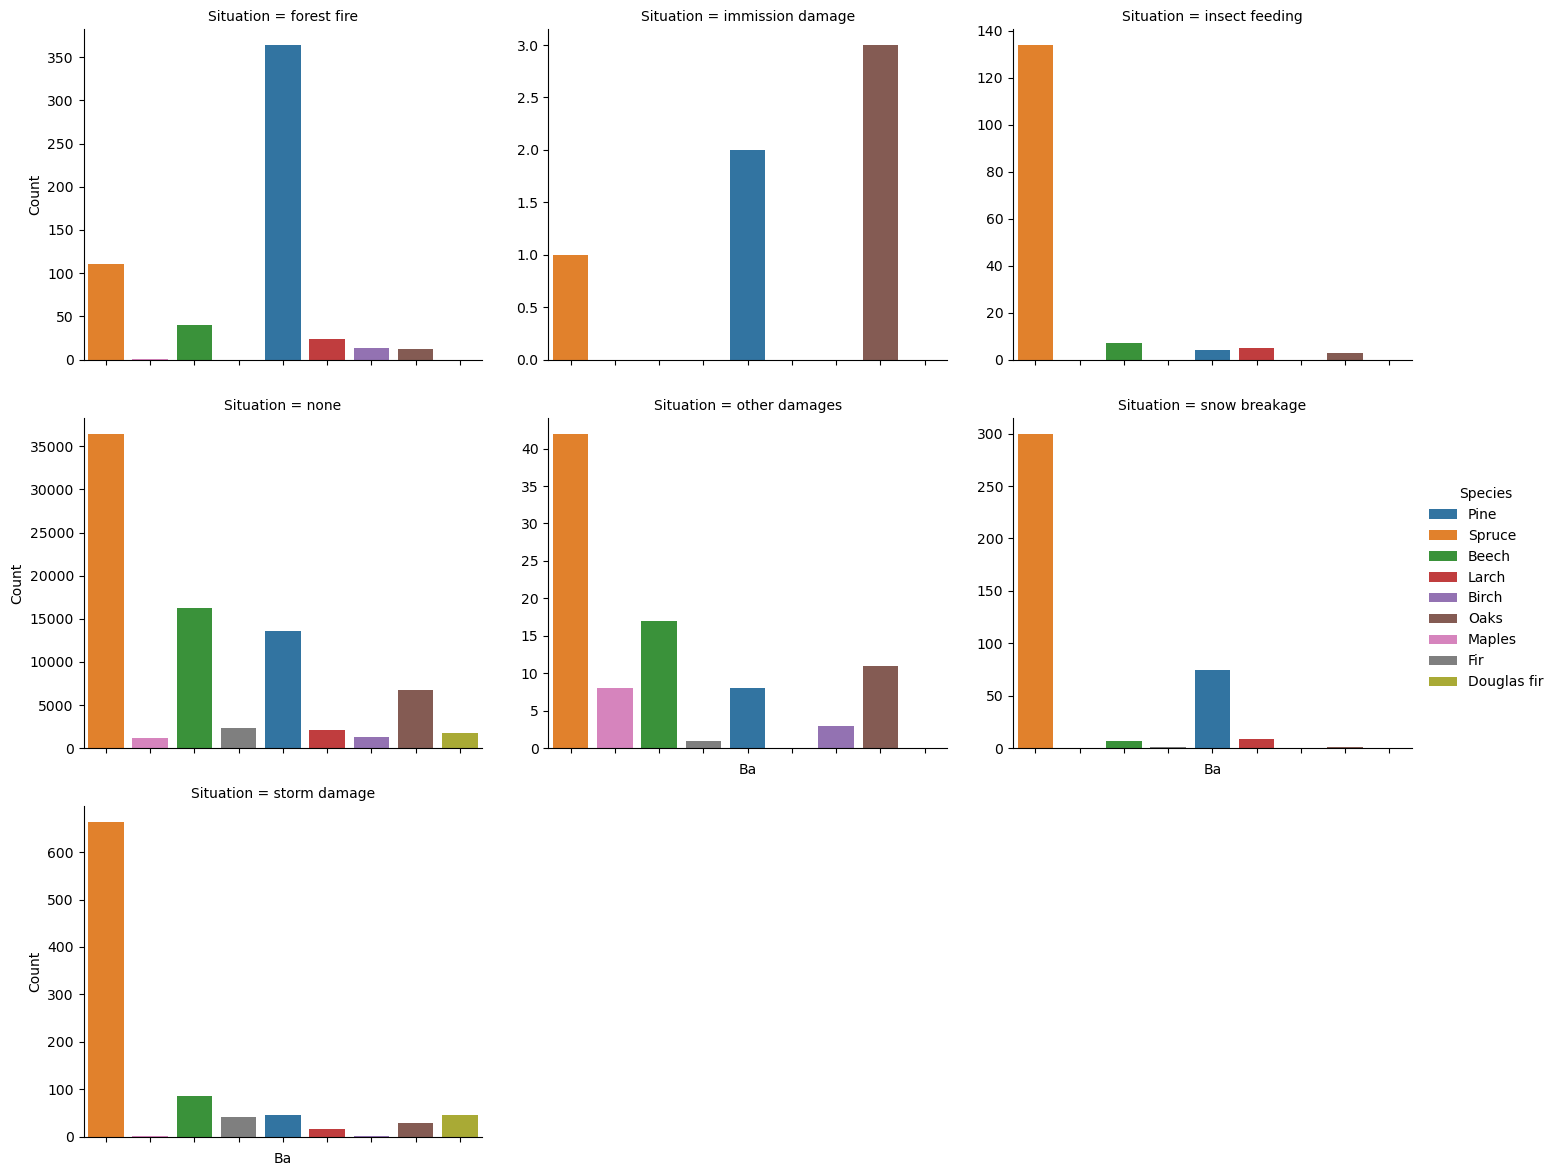

In [61]:
plot_categorical_feature(data_cop, 'Situation', col_wrap=3)

We can observe that spruces account for the most counts in every subcategory. In addition, the counts for tree species in subcategories less dominated by spruce are very low. We would assume that the feature does not help much in explainaing the variance of the dataset.

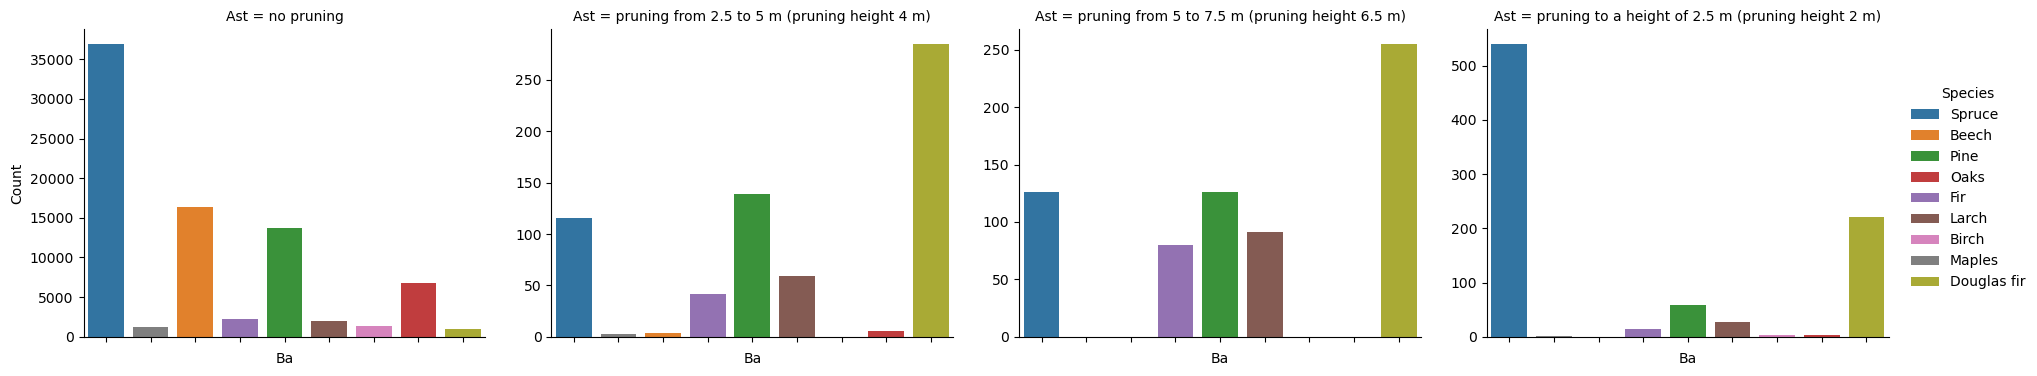

In [62]:
plot_categorical_feature(data_cop, 'Ast', col_wrap=4)

As expected the pruning feature indicates differences between the deciduous and coniferous species. We can observe that pruning in heights > 5m is more common to douglas fir. The feature might be helpful to distinguish between the two species groups and between the coniferous trees. Even though the counts in the subclasses is relatively low compared to the non prunning subcategory.

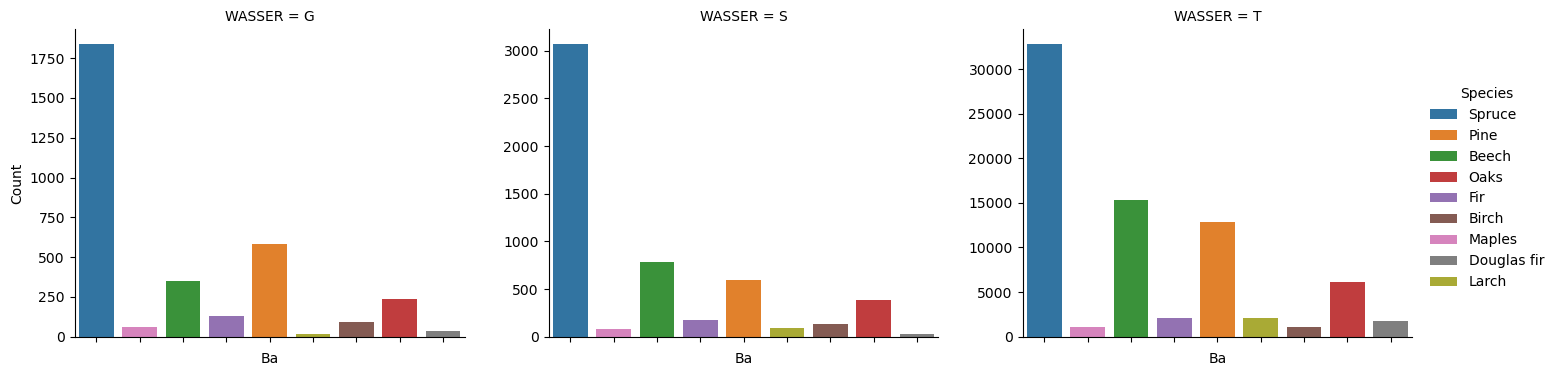

In [63]:
plot_categorical_feature(data_cop, 'WASSER')

As in the other features described above, the spruce is dominat for all subcategories. In addition the relative distribution of tree species depending on the main water impact type seems to be similar.  

In [64]:
# Removing Bs feature
data_cop.drop(columns='Bs', inplace=True)

In [65]:
data_cop.to_csv('../datasets/ml_bwi_intotraining.csv', index=False)

In [66]:
data_cop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83908 entries, 0 to 190272
Data columns (total 50 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Tnr            83908 non-null  int64  
 1   Enr            83908 non-null  int64  
 2   Ba             83908 non-null  object 
 3   Al_ba          83908 non-null  float64
 4   Bhd            83908 non-null  int64  
 5   Hoehe          83908 non-null  float64
 6   D7             83908 non-null  float64
 7   D03            83908 non-null  float64
 8   G              83908 non-null  float64
 9   VolR           83908 non-null  float64
 10  N_ha           83908 non-null  float64
 11  Stf            83908 non-null  float64
 12  Biom_o         83908 non-null  float64
 13  Biov_o         83908 non-null  float64
 14  Gexp           83908 non-null  float64
 15  Gform          83908 non-null  object 
 16  Gneig          83908 non-null  int64  
 17  natHoe         83908 non-null  object 
 18  HoeheNN   

## Final dataset 
After the choices made above the dataset consists of one target variable and 46 explanatory variables (12 categorical and 34 numerical). The included variables are the following: 

### Feature descriptions

In [67]:
from IPython.display import Markdown

# Read the file and display the table
file_path = '../documentation/features_fd.md'
with open(file_path, 'r') as file:
    content = file.read()

# Display the content as markdown
display(Markdown(content))

# Feature descriptions - final dataset - 
| Feature         | Description | Type |
|:----------------|:------------|------:|
| Ba              | 'Baumart: Tree species | Categorical **TARGET** |
| Al_ba           | 'Baumalter: Tree age [$a$] | Numerical |
| Bhd             | 'Brusthöhendurchmesser: Diameter at breast height [$mm$] | Numerical |
| Hoehe           | 'Höhe': Height [$dm$] | Numerical |
| D7              | Diameter at 0.7 percentile of tree height | Numerical |
| D03             | Diameter at 0.3 percentile of tree height | Numerical |
| G               | 'Grundfläche': Basal area [$m^2$] | Numerical |
| VolR            | 'Volumen Vorratsfestmeter': Volume with bark [$m^3$] | Numerical |
| N_ha            | 'Stammzahl je Hektar': Number of trees per hectare | Numerical |
| Stf             | 'Standfläche': 'Canopy footprint' [$m^2$] | Numerical |
| Biom_o          | 'Biomasse oberirdisch': Aboveground biomass [$kg$] | Numerical |
| Biov_o          | 'Biomasse überirdisch': Aboveground biomass [$m^3$] | Numerical |
| Gexp            | 'Geländexposition': Aspect [$gon$] | Numerical |
| Gform           | 'Geländeform': Terrain | Categorical |
| Gneig           | 'Geländeneigung': Slope [$\%$] | Numerical |
| natHoe          | 'natürliche Höhenstufe': Natural height class | Categorical |
| HoeheNN         | 'Höhe NN': Height above German normal height [$m$] | Numerical |
| Be              | 'Betriebsart': Operation category | Categorical |
| NatNaeheHaupt   | 'Ermittelte Naturnähe (durch Hauptbestand WZP-4)': Estimated closeness to nature (using the main canopy layer) | Categorical |
| Situation       | 'Besondere Bestandessituation': Special forest stand situation | Categorical |
| TOT             | 'Anzahl Totholzstücke': Pieces of deadwood | Numerical |
| Bkl             | 'Baumklasse': Tree social class | Categorical |
| Ast             | 'Astung' | Categorical |
| BestockAb       | 'Bestockungsaufbau': Forest stories | Categorical |
| BODTYP          | 'Bodentyp': Soil type | Categorical |
| NAEHR           | 'Nährstoffkraft': Nutritive power | Categorical |
| WASSER          | 'Wasserhaushaltstufe': Water budget bin | Categorical |
| nfk_30          | 'Feldkapazität 30cm': Water holding capacity in 30cm | Numerical |
| bio_1           | Annual mean temperature (1992-2002) as the mean of the monthly temperatures in [$°C$] | Numerical |
| bio_2           | Mean diurnal range (1992-2002) as the mean of monthly (max temp - min temp) in [$°C$] | Numerical |
| bio_3           | Isothermality (1992-2002) in [$°C$] | Numerical |
| bio_4           | Temperature seasonality (1992-2002) in [$°C$] | Numerical |
| bio_5           | Max temperature of warmest month (1992-2002) in [$°C$] | Numerical |
| bio_6           | Min temperature of coldest month (1992-2002) in [$°C$] | Numerical |
| bio_7           | Temperature annual range (1992-2002) (bio_5 - bio_6) in [$°C$] | Numerical |
| bio_8           | Mean temperature of wettest quarter (1992-2002) in [$°C$] | Numerical |
| bio_9           | Mean temperature of driest quarter (1992-2002) in [$°C$] | Numerical |
| bio_10          | Mean temperature of warmest quarter (1992-2002) in [$°C$] | Numerical |
| bio_11          | Mean temperature of coldest quarter (1992-2002) in [$°C$] | Numerical |
| bio_12          | Annual precipitation (1992-2002) in [$mm$] | Numerical |
| bio_13          | Precipitation of wettest month (1992-2002) in [$mm$] | Numerical |
| bio_14          | Precipitation of driest month (1992-2002) in [$mm$] | Numerical |
| bio_15          | Precipitation seasonality (1992-2002) in [$mm$] | Numerical |
| bio_16          | Precipitation of wettest quarter (1992-2002) in [$mm$] | Numerical |
| bio_17          | Precipitation of driest quarter (1992-2002) in [$mm$] | Numerical |
| bio_18          | Precipitation of warmest quarter (1992-2002) in [$mm$] | Numerical |
| bio_19          | Precipitation of coldest quarter (1992-2002) in [$mm$] | Numerical |

### Aggregation levels and grouping
Three aggregation levels are present in the dataset. The lowest is on the individual tree or instance level. The second is the sample plot level (Enr) and highest is the grid level (Tnr). In order to group the instances the aim is to combine Tnr and Enr for stratified cross-validation.